In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
#from cnn_utils import *

%matplotlib inline
np.random.seed(1)

C:\Users\Amit\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [5]:
y_train=np.reshape(y_train,(1,60000))
y_test=np.reshape(y_test,(1,10000))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (1, 60000) (10000, 28, 28) (1, 10000)


y = 4


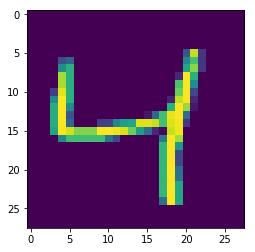

In [6]:
index = 2
plt.imshow(x_train[index])
print ("y = " + str(np.squeeze(y_train[:,index])))


In [7]:
X_train = x_train/255.
X_test = x_test/255.
Y_train =np.zeros((y_train.shape[1],10))
Y_train[np.arange(y_train.shape[1]), y_train] = 1
Y_test =np.zeros((y_test.shape[1],10))
Y_test[np.arange(y_test.shape[1]), y_test] = 1

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28)
Y_test shape: (10000, 10)


In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32,shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32,shape=(None, n_y))
    
    return X, Y

In [9]:
def initialize_parameters():
    
    W1 = tf.get_variable("W1", [4,4,1,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [10]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1],padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    P = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P, 10, activation_fn=None)
    
    return Z3

In [11]:
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [30]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            
    m = X.shape[0]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[ permutation,:,:,:]
    shuffled_Y = Y[ permutation,:]

    
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [31]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    X_train=np.reshape(X_train,(60000, 28, 28,1))
    X_test=np.reshape(X_test,(10000, 28, 28,1))
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(100):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = 0
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 0.476279
Cost after epoch 5: 0.172056
Cost after epoch 10: 0.156071
Cost after epoch 15: 0.149955
Cost after epoch 20: 0.143456
Cost after epoch 25: 0.138758
Cost after epoch 30: 0.137426
Cost after epoch 35: 0.135506
Cost after epoch 40: 0.135824
Cost after epoch 45: 0.134441
Cost after epoch 50: 0.132957
Cost after epoch 55: 0.132818
Cost after epoch 60: 0.131923
Cost after epoch 65: 0.130641
Cost after epoch 70: 0.128953
Cost after epoch 75: 0.128477
Cost after epoch 80: 0.126983
Cost after epoch 85: 0.126572
Cost after epoch 90: 0.126926
Cost after epoch 95: 0.125989


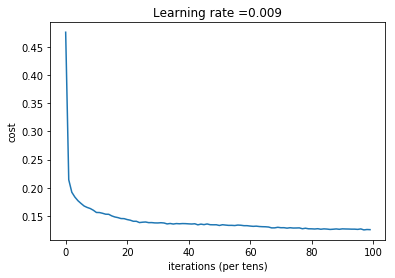

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.95418334
Test Accuracy: 0.954


In [32]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
